In [1]:
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

plotly.offline.init_notebook_mode(connected=True)


import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED=44

In [2]:
manufacturer_to_country = {
    'LEXUS': 'Japan',
    'CHEVROLET': 'USA',
    'HONDA': 'Japan',
    'FORD': 'USA',
    'HYUNDAI': 'South Korea',
    'TOYOTA': 'Japan',
    'MERCEDES-BENZ': 'Germany',
    'OPEL': 'Germany',
    'PORSCHE': 'Germany',
    'BMW': 'Germany',
    'JEEP': 'USA',
    'VOLKSWAGEN': 'Germany',
    'AUDI': 'Germany',
    'RENAULT': 'France',
    'NISSAN': 'Japan',
    'SUBARU': 'Japan',
    'DAEWOO': 'South Korea',
    'KIA': 'South Korea',
    'MITSUBISHI': 'Japan',
    'SSANGYONG': 'South Korea',
    'MAZDA': 'Japan',
    'GMC': 'USA',
    'FIAT': 'Italy',
    'INFINITI': 'Japan',
    'ALFA ROMEO': 'Italy',
    'SUZUKI': 'Japan',
    'ACURA': 'Japan',
    'LINCOLN': 'USA',
    'VAZ': 'Russia',
    'GAZ': 'Russia',
    'CITROEN': 'France',
    'LAND ROVER': 'UK',
    'MINI': 'UK',
    'DODGE': 'USA',
    'CHRYSLER': 'USA',
    'JAGUAR': 'UK',
    'ISUZU': 'Japan',
    'SKODA': 'Czech Republic',
    'DAIHATSU': 'Japan',
    'BUICK': 'USA',
    'TESLA': 'USA',
    'CADILLAC': 'USA',
    'PEUGEOT': 'France',
    'BENTLEY': 'UK',
    'VOLVO': 'Sweden',
    'სხვა': 'Georgia',
    'HAVAL': 'China',
    'HUMMER': 'USA',
    'SCION': 'Japan',
    'UAZ': 'Russia',
    'MERCURY': 'USA',
    'ZAZ': 'Ukraine',
    'ROVER': 'UK',
    'SEAT': 'Spain',
    'LANCIA': 'Italy',
    'MOSKVICH': 'Russia',
    'MASERATI': 'Italy',
    'FERRARI': 'Italy',
    'SAAB': 'Sweden',
    'LAMBORGHINI': 'Italy',
    'ROLLS-ROYCE': 'UK',
    'PONTIAC': 'USA',
    'SATURN': 'USA',
    'ASTON MARTIN': 'UK',
    'GREATWALL': 'China'
}

dict_leather_interior = {
    'Yes': 1, 
    'No': 0
}

doors_to_words = {
    '4-5': 'four_to_five',
    '2-3': 'two_to_three',
    '>5': 'more_than_five'
}

In [3]:
def data_preprocessing(df):
    df['levy'] = df['levy'].replace('-', 0)
    df['levy'] = df['levy'].astype(int)
    
    df['manufacturer'] = df['manufacturer'].map(manufacturer_to_country)
    countries_to_drop = ['Georgia', 'China', 'Ukraine', 'Spain']
    df = df[~df['manufacturer'].isin(countries_to_drop)]
    
    df['mileage'] = df['mileage'].str.replace(' km', '').astype(int)
    
    df['turbo_engine'] = df['turbo_engine'].astype(int)
    
    df['leather_interior'] = df['leather_interior'].map(dict_leather_interior)
    
    df = df[df['fuel_type'] != 'Hydrogen']
    df['fuel_type'] = df['fuel_type'].replace('Plug-in Hybrid ', 'Hybrid')
    
    df['doors'] = df['doors'].replace(doors_to_words)
    
    df['left_wheel'] = df['left_wheel'].astype(int)
    
    return df

In [4]:
def delete_outliers(df):
    df = df[(df['production_year'] > 1998) & (df['production_year'] < 2021)]
    df = df[df['price'] < 41000]
    df = df[df['levy'] < 2200]
    df = df[df['engine_volume'] < 4]
    df = df[df['mileage'] < 330000]
    
    return df

In [5]:
def one_hot_encode(df, column, prefix):
    one_hot_columns = pd.get_dummies(df[column], prefix=prefix)
    one_hot_columns = one_hot_columns.astype(int)
    df.drop(column, axis=1, inplace=True)
    
    return pd.concat([df, one_hot_columns], axis=1)

In [6]:
def encode_columns(df):
    df = one_hot_encode(df, 'manufacturer', 'manufacturer')
    df = one_hot_encode(df, 'fuel_type', 'fuel_type')
    df = one_hot_encode(df, 'gear_box_type', 'gear_box_type')
    df = one_hot_encode(df, 'doors', 'doors')
    df = one_hot_encode(df, 'drive_wheels', 'drive_wheels')
    df = one_hot_encode(df, 'category', 'category')
    
    return df

In [7]:
def boxplot(df, column):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df)
    plt.title(f"Box Plot of {column} column")
    plt.show()

In [8]:
def visualize_boxplots(df, columns):
    num_cols = df[columns].shape[1]
    num_rows = num_cols // 3 + (num_cols % 3 > 0)

    colors = sns.color_palette('husl', num_cols)

    fig, ax = plt.subplots(num_rows, 3, figsize=(12, num_rows * 5))  # Width is fixed, height changes with number of rows

    ax = ax.flatten()

    for i, column in enumerate(columns):
        sns.boxplot(data=df[column], ax=ax[i], color=colors[i])
        ax[i].set_title(f'Boxplot of {column}', fontsize=10)
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

    for j in range(i+1, num_rows * 3):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
def plot_3d_features(df, feature1, feature2, feature3, label):# Sample feature selection - replace with your actual feature names
    fig = px.scatter_3d(df, x=feature1, y=feature2, z=feature3, color=label, 
                        color_continuous_scale=px.colors.sequential.Viridis)

    fig.update_layout(title='3D Scatter Plot of Features Colored by Price',
                      scene=dict(
                          xaxis_title=feature1,
                          yaxis_title=feature2,
                          zaxis_title=feature3
                      ))

    fig.show()

In [10]:
def plot_residuals(self, y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(title)

In [11]:
def evaluate(y_pred, y_test):
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

In [12]:
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(title)

In [13]:
def plot_3d_features(df, feature1, feature2, feature3, label):# Sample feature selection - replace with your actual feature names
    fig = px.scatter_3d(df, x=feature1, y=feature2, z=feature3, color=label, 
                        color_continuous_scale=px.colors.sequential.Viridis)

    fig.update_layout(title='3D Scatter Plot of Features Colored by Price',
                      scene=dict(
                          xaxis_title=feature1,
                          yaxis_title=feature2,
                          zaxis_title=feature3
                      ))

    fig.show()

In [14]:
column_names = ['id', 'price', 'levy', 'manufacturer', 'model', 'production_year', 
                'category', 'leather_interior', 'fuel_type', 'engine_volume',
                'mileage', 'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 
                'color', 'airbags', 'turbo_engine', 'left_wheel']

In [15]:
df = pd.read_csv('zadanie2_dataset.csv', names=column_names, header=0)

Odstranenie stlpcov s identifikatormi

In [16]:
df = df[(df['cylinders'] <= 8) & (df['cylinders'] >= 3)]

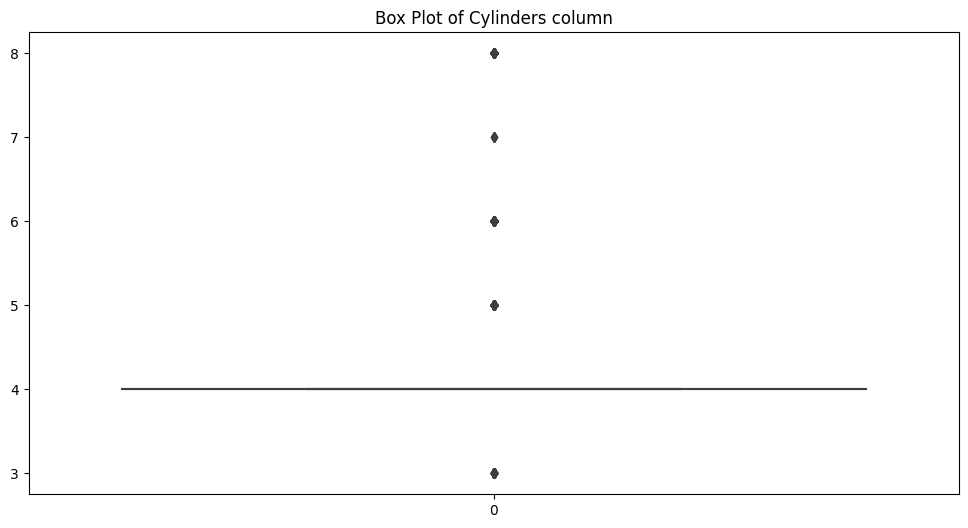

In [17]:
boxplot(df['cylinders'], "Cylinders")

In [18]:
df['cylinders'].value_counts()

cylinders
4    14367
6     3462
8      991
5      169
3      107
7        4
Name: count, dtype: int64

In [19]:
df.drop(['id', 'color', 'cylinders', 'model'], axis=1, inplace=True)

In [20]:
df = data_preprocessing(df)

In [21]:
df.shape[0]

19092

Odstranenie duplicitnych hodnot

In [22]:
df.drop_duplicates(inplace=True)

In [23]:
df.shape[0]

15545

In [24]:
df.dropna(inplace=True)

In [25]:
df.shape[0]

15545

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15545 entries, 0 to 19236
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             15545 non-null  float64
 1   levy              15545 non-null  int64  
 2   manufacturer      15545 non-null  object 
 3   production_year   15545 non-null  int64  
 4   category          15545 non-null  object 
 5   leather_interior  15545 non-null  int64  
 6   fuel_type         15545 non-null  object 
 7   engine_volume     15545 non-null  float64
 8   mileage           15545 non-null  int64  
 9   gear_box_type     15545 non-null  object 
 10  drive_wheels      15545 non-null  object 
 11  doors             15545 non-null  object 
 12  airbags           15545 non-null  int64  
 13  turbo_engine      15545 non-null  int64  
 14  left_wheel        15545 non-null  int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 1.9+ MB


In [27]:
columns_outliers = ['price', 'levy', 'production_year', 'engine_volume', 'mileage', 'airbags']

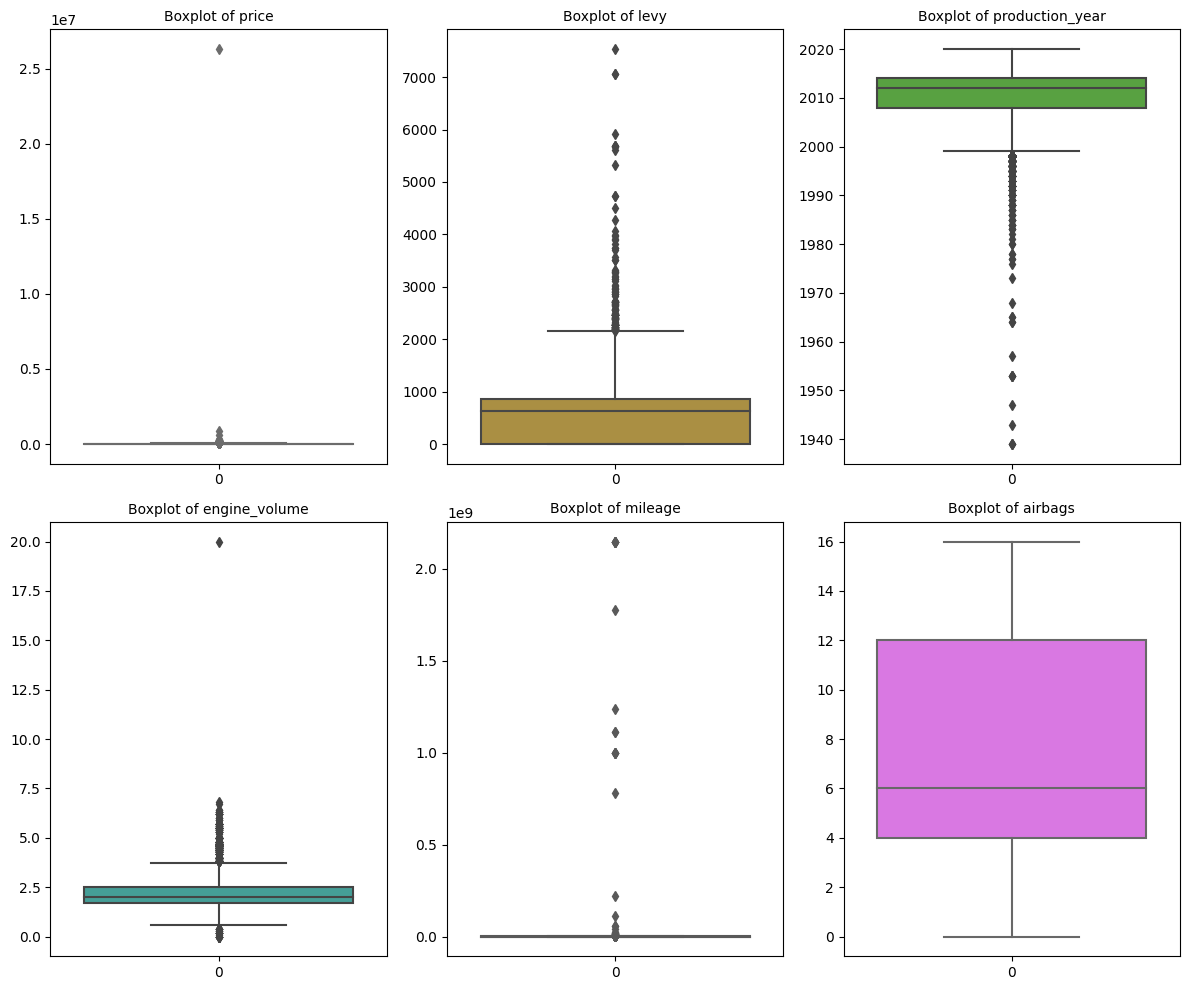

In [28]:
visualize_boxplots(df, columns_outliers)

In [29]:
df = delete_outliers(df)

In [30]:
df.shape[0]

12381

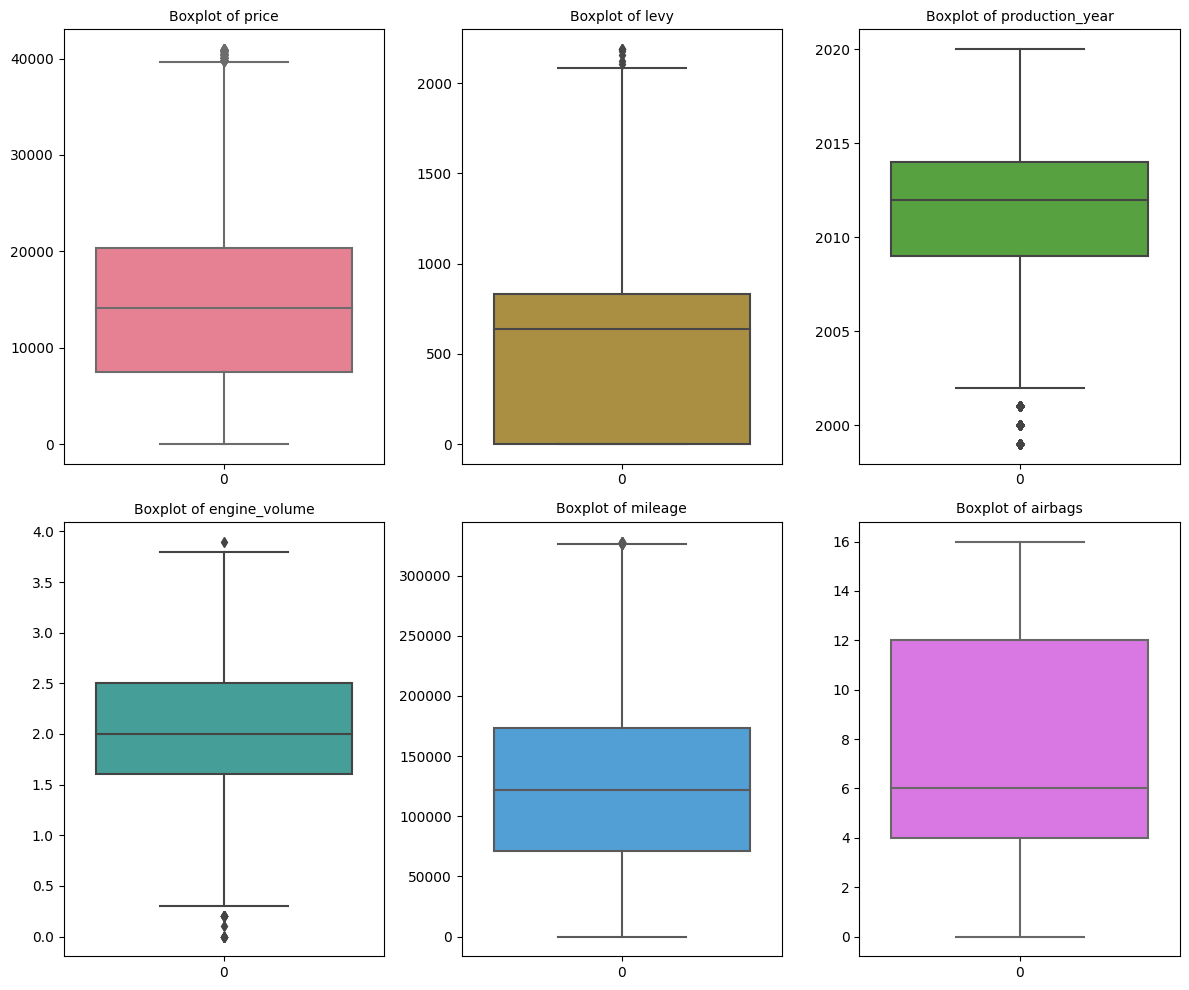

In [31]:
visualize_boxplots(df, columns_outliers)

In [32]:
df = encode_columns(df)

In [33]:
df.shape[0]

12381

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12381 entries, 0 to 19236
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        12381 non-null  float64
 1   levy                         12381 non-null  int64  
 2   production_year              12381 non-null  int64  
 3   leather_interior             12381 non-null  int64  
 4   engine_volume                12381 non-null  float64
 5   mileage                      12381 non-null  int64  
 6   airbags                      12381 non-null  int64  
 7   turbo_engine                 12381 non-null  int64  
 8   left_wheel                   12381 non-null  int64  
 9   manufacturer_Czech Republic  12381 non-null  int64  
 10  manufacturer_France          12381 non-null  int64  
 11  manufacturer_Germany         12381 non-null  int64  
 12  manufacturer_Italy           12381 non-null  int64  
 13  manufacturer_Japan   

In [35]:
class MyDecisionTreeRegressor:
    
    def train_models(self, tree_params, X_train, y_train):
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_SEED)
        
        self.best_mse = float('inf')
        self.best_r2 = float('-inf')
        self.best_model = None
        
        for params in tree_params:
            tree = DecisionTreeRegressor(random_state=RANDOM_SEED, **params)
            tree.fit(X_train, y_train)
            y_pred = tree.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)
#             print(f"Parameters: {params}, Mean Squared Error: {mse}, R2 Score: {r2}")

            if mse < self.best_mse:
                self.best_mse = mse
                self.best_r2 = r2
                self.best_params = params
                self.best_model = tree
                
        print(f"Best Model Parameters: {self.best_params}, Best Mean Squared Error: {self.best_mse}, Best R2 Score: {self.best_r2}")
        

    def predict(self, X_test):
         return self.best_model.predict(X_test)
    
    
    def visualize_tree(self, columns):
        plt.figure(figsize=(20, 10))  # Set the figure size (adjust as needed)
        plot_tree(self.best_model, filled=True, feature_names=columns, rounded=True)
        plt.title("Decision Tree Regressor")
        plt.savefig('decision_tree_visualization.png')
        plt.show()

In [36]:
class MyRandomForestRegressorCV:
    
    def train_model(self, param_distributions, X_train, y_train):
        rf = RandomForestRegressor(random_state=RANDOM_SEED)
        rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=10, cv=5, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
        rf_random.fit(X_train, y_train)
    
        self.best_rf = rf_random.best_estimator_
        self.best_params = rf_random.best_params_
        
    def plot_important_features(self, columns, top=None):
        importances = self.best_rf.feature_importances_
        feature_importances = pd.DataFrame({'feature': columns, 'importance': importances})
        
        if top is not None:
            feature_importances = feature_importances.sort_values(by='importance', ascending=False).head(top)
        else:
            feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', data=feature_importances)

        plt.title('Feature Importances')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()
        
    def predict(self, X_test):
        return self.best_rf.predict(X_test)
    
    
#         print(f"Mean Squared Error: {mse}, R2 Score: {r2}")

## Rozdelenie dat na trenovaciu a testovaciu mnozinu

In [37]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [100]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [101]:
params = [
    {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 40},
    {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 40},
    {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 20},
    {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 4},
    {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 4},
    {'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 30},
]

In [102]:
my_tree = MyDecisionTreeRegressor()
my_tree.train_models(params, X_train, y_train)

y_pred_my_tree_train = my_tree.predict(X_train)
y_pred_my_tree_test = my_tree.predict(X_test)

mse_my_tree_train, r2_my_tree_train = evaluate(y_pred_my_tree_train, y_train)
mse_my_tree_test, r2_my_tree_test = evaluate(y_pred_my_tree_test, y_test)

rmse_my_tree_train = np.sqrt(mse_my_tree_train)
rmse_my_tree_test = np.sqrt(mse_my_tree_test)

print(f"DecisionTree - Train: Mean Squared Error: {mse_my_tree_train}, R2 Score: {r2_my_tree_train}, RMSE: {rmse_my_tree_train}")
print(f"DecisionTree - Test: Mean Squared Error: {mse_my_tree_test}, R2 Score: {r2_my_tree_test}, RMSE: {rmse_my_tree_test}")

Best Model Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 40}, Best Mean Squared Error: 38996615.0919952, Best R2 Score: 0.6009219237242057
DecisionTree - Train: Mean Squared Error: 34123009.30934669, R2 Score: 0.6515180294862007, RMSE: 5841.490332898506
DecisionTree - Test: Mean Squared Error: 37321020.64248072, R2 Score: 0.607493680132541, RMSE: 6109.093274986127


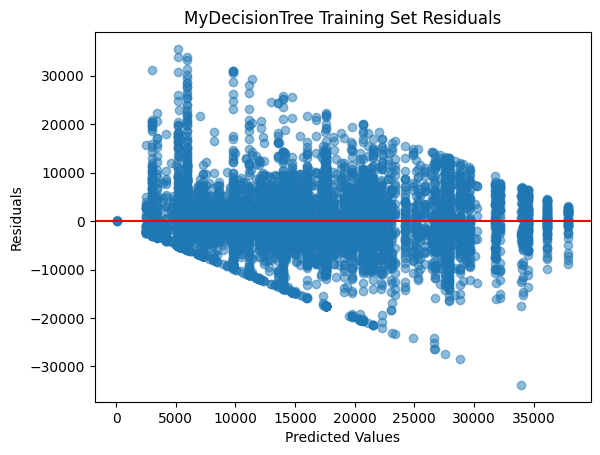

In [103]:
plot_residuals(y_train, y_pred_my_tree_train, 'MyDecisionTree Training Set Residuals')

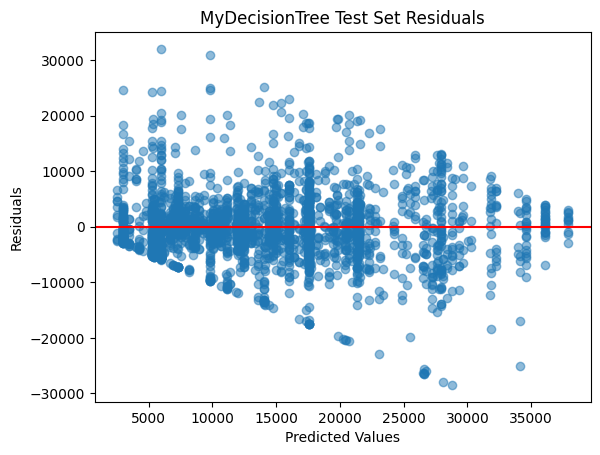

In [104]:
plot_residuals(y_test, y_pred_my_tree_test, 'MyDecisionTree Test Set Residuals')

Best Model Parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 40}, Best Mean Squared Error: 69090728.40966919, Best R2 Score: 0.2929490183396982
DecisionTree - Visual - Test: Mean Squared Error: 66923201.52024886, R2 Score: 0.2961666350420794


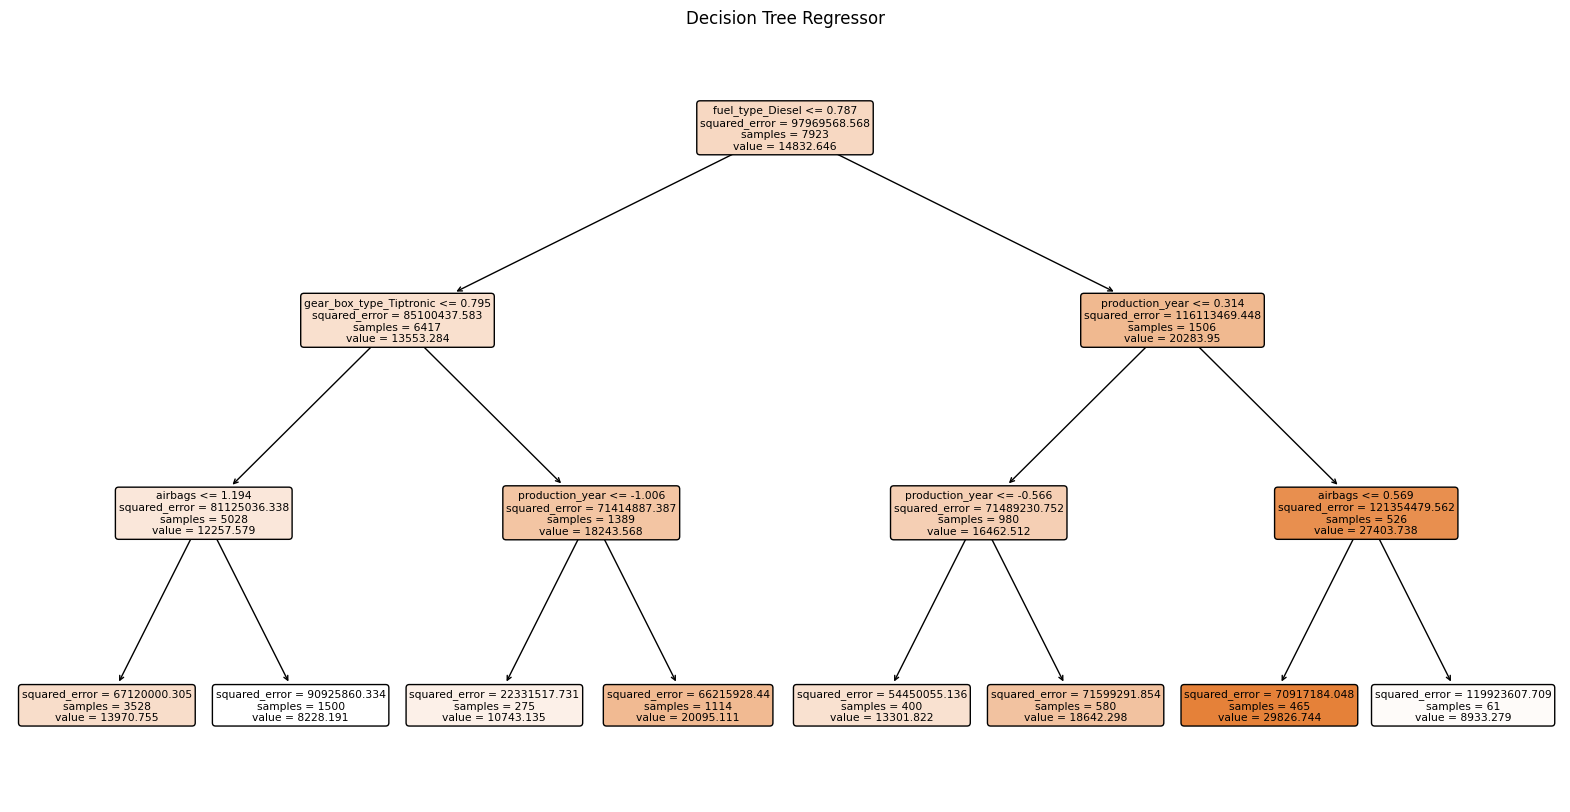

In [105]:
params = [
    {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 40},
]
my_tree_visual = MyDecisionTreeRegressor()
my_tree_visual.train_models(params, X_train, y_train)

y_pred_visual = my_tree_visual.predict(X_test)
mse_my_tree_visual, r2_my_tree_visual = evaluate(y_pred_visual, y_test)

print(f"DecisionTree - Visual - Test: Mean Squared Error: {mse_my_tree_visual}, R2 Score: {r2_my_tree_visual}")

my_tree_visual.visualize_tree(X.columns)

## Stromovy suborovy model

In [106]:
param_distributions = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [47]:
%%time
my_rf = MyRandomForestRegressorCV()
my_rf.train_model(param_distributions, X_train, y_train)

y_pred_my_rf_train = my_rf.predict(X_train)
y_pred_my_rf_test = my_rf.predict(X_test)

mse_my_rf_train, r2_my_rf_train = evaluate(y_pred_my_rf_train, y_train)
mse_my_rf_test, r2_my_rf_test = evaluate(y_pred_my_rf_test, y_test)

rmse_my_rf_train = np.sqrt(mse_my_rf_train)
rmse_my_rf_test = np.sqrt(mse_my_rf_test)

print("Best Parameters of MyRandomForestRegressorCV:", my_rf.best_params)
print(f"MyRandomForest - Train: Mean Squared Error: {mse_my_rf_train}, R2 Score: {r2_my_rf_train}  RMSE: {rmse_my_rf_train}")
print(f"MyRandomForest - Test: Mean Squared Error: {mse_my_rf_test}, R2 Score: {r2_my_rf_test} RMSE: {rmse_my_rf_test}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters of MyRandomForestRegressorCV: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 30}
MyRandomForest - Train: Mean Squared Error: 16650678.726360137, R2 Score: 0.8299545834204952  RMSE: 4080.524320030471
MyRandomForest - Test: Mean Squared Error: 30383973.11202904, R2 Score: 0.6804508219804775 RMSE: 5512.165918405309
CPU times: user 5.22 s, sys: 140 ms, total: 5.36 s
Wall time: 47.9 s


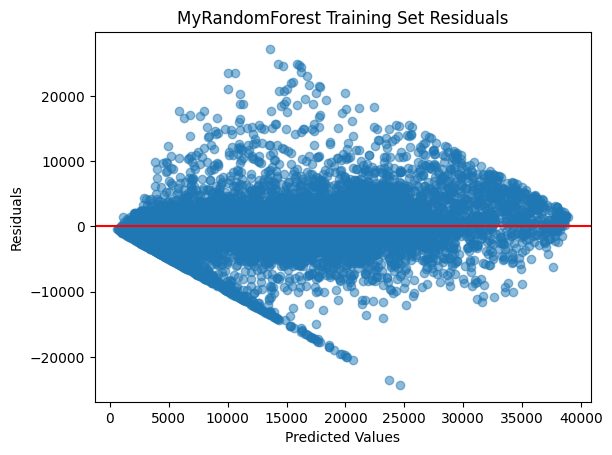

In [48]:
plot_residuals(y_train, y_pred_my_rf_train, 'MyRandomForest Training Set Residuals')

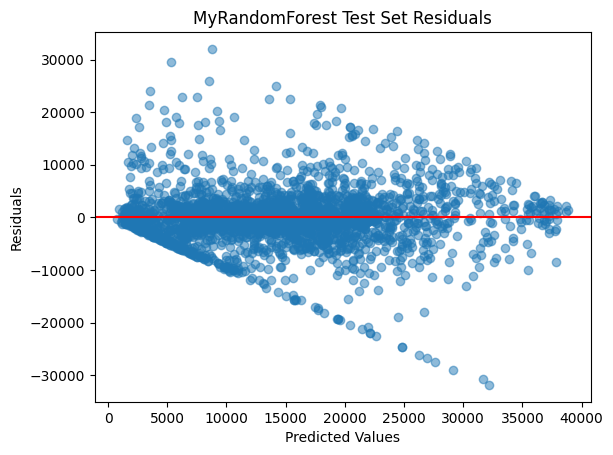

In [49]:
plot_residuals(y_test, y_pred_my_rf_test, 'MyRandomForest Test Set Residuals')

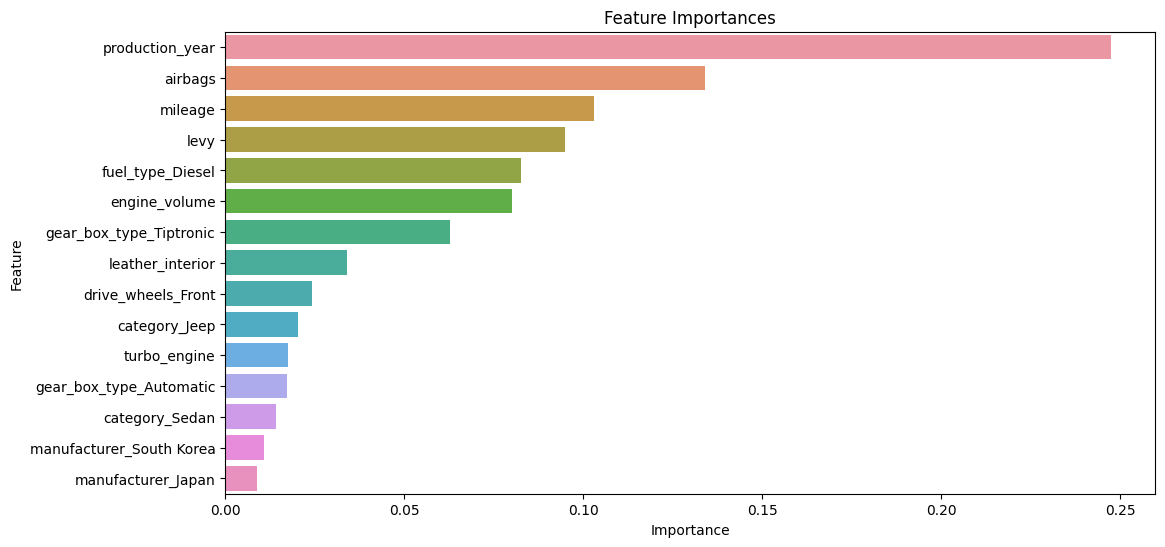

In [50]:
my_rf.plot_important_features(X.columns, top=15)

## SVM

In [51]:
%%time
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

best_svr = grid_search.best_estimator_

Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
CPU times: user 5.48 s, sys: 150 ms, total: 5.63 s
Wall time: 2min 31s


In [52]:
y_pred_svc_train = best_svr.predict(X_train)
y_pred_svc_test = best_svr.predict(X_test)

mse_svc_train, r2_svc_train = evaluate(y_pred_svc_train, y_train)
mse_svc_test, r2_svc_test = evaluate(y_pred_svc_test, y_test)

rmse_svc_train = np.sqrt(mse_svc_train)
rmse_svc_test = np.sqrt(mse_svc_test)

print(f"SVC - Train: Mean Squared Error: {mse_svc_train}, R2 Score: {r2_svc_train} RMSE: {rmse_svc_train}")
print(f"SVC - Test: Mean Squared Error: {mse_svc_test}, R2 Score: {r2_svc_test} RMSE: {rmse_svc_test}")

SVC - Train: Mean Squared Error: 64524352.34022038, R2 Score: 0.34104365632583267 RMSE: 8032.705169506745
SVC - Test: Mean Squared Error: 63065151.617638744, R2 Score: 0.33674186431152864 RMSE: 7941.35703879625


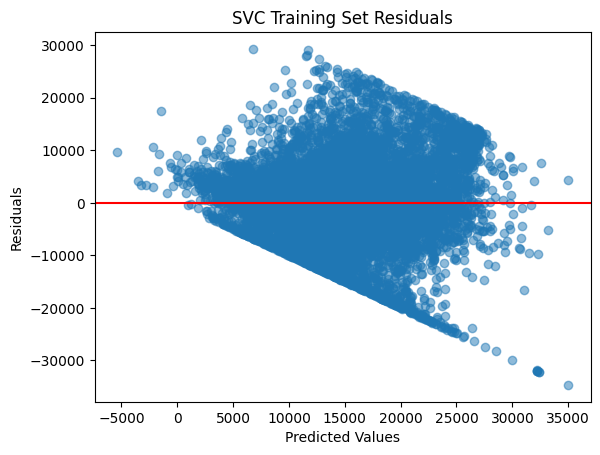

In [53]:
plot_residuals(y_train, y_pred_svc_train, 'SVC Training Set Residuals')

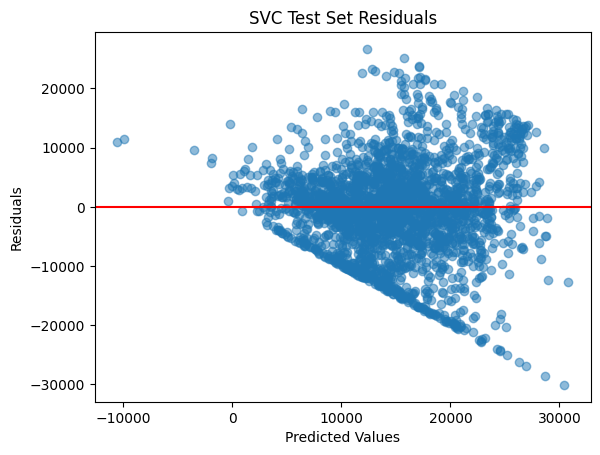

In [54]:
plot_residuals(y_test, y_pred_svc_test, 'SVC Test Set Residuals')

In [55]:
pd.options.display.float_format = '{:.2e}'.format 
data = [
    [mse_my_tree_train, rmse_my_tree_train, r2_my_tree_train, mse_my_tree_test, rmse_my_tree_test, r2_my_tree_test],
    [mse_my_rf_train, rmse_my_rf_train,r2_my_rf_train, mse_my_rf_test, rmse_my_rf_test, r2_my_rf_test],
    [mse_svc_train, rmse_svc_train, r2_svc_train, mse_svc_test, rmse_svc_test, r2_svc_test]
]

metrics = pd.DataFrame(
    index=['DecisionTree', 'RandomForest', 'SVM'],
    columns=['MSE Train', 'RMSE Train', 'R2 Train', 'MSE Test', 'RMSE Test', 'R2 Test'],
    data=data
)
print(metrics)

              MSE Train  RMSE Train  R2 Train  MSE Test  RMSE Test  R2 Test
DecisionTree   3.41e+07    5.84e+03  6.52e-01  3.73e+07   6.11e+03 6.07e-01
RandomForest   1.67e+07    4.08e+03  8.30e-01  3.04e+07   5.51e+03 6.80e-01
SVM            6.45e+07    8.03e+03  3.41e-01  6.31e+07   7.94e+03 3.37e-01


## Analyza troch priznakov

In [107]:
column_names = ['id', 'price', 'levy', 'manufacturer', 'model', 'production_year', 
                'category', 'leather_interior', 'fuel_type', 'engine_volume',
                'mileage', 'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 
                'color', 'airbags', 'turbo_engine', 'left_wheel']
df_analyze = pd.read_csv('zadanie2_dataset.csv', names=column_names, header=0)

In [108]:
df_analyze.drop(['id', 'color', 'cylinders', 'model'], axis=1, inplace=True)

In [109]:
df_analyze = data_preprocessing(df_analyze)
df_analyze.drop_duplicates(inplace=True)
df_analyze.dropna(inplace=True)
df_analyze = delete_outliers(df_analyze)

In [110]:
df_analyze.shape[0]

12462

In [111]:
plot_3d_features(df_analyze, 'mileage', 'production_year', 'fuel_type', 'price')

## Minimalizacia mnozinu parametrov na 3 dimenzie

In [112]:
analyze_data = df_analyze.drop('price', axis=1)
analyze_label = df_analyze['price']

numeric_features = analyze_data.select_dtypes(include=[np.number])
numeric_features.columns

scaler = StandardScaler()
numeric_features = scaler.fit_transform(numeric_features)


pca = PCA(n_components=3)
pca_result = pca.fit_transform(numeric_features)

df_pca = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2', 'PCA3'])

In [113]:
df_pca['price'] = analyze_label
plot_3d_features(df_pca, 'PCA1', 'PCA2', 'PCA3', 'price')

# Vyber podmnozinu priznakov

Natrénovanie najúspešnejšieho modelu z prvej časti zadania
a opät pre zmenšenú množinu

## Podla korelacnej matice 

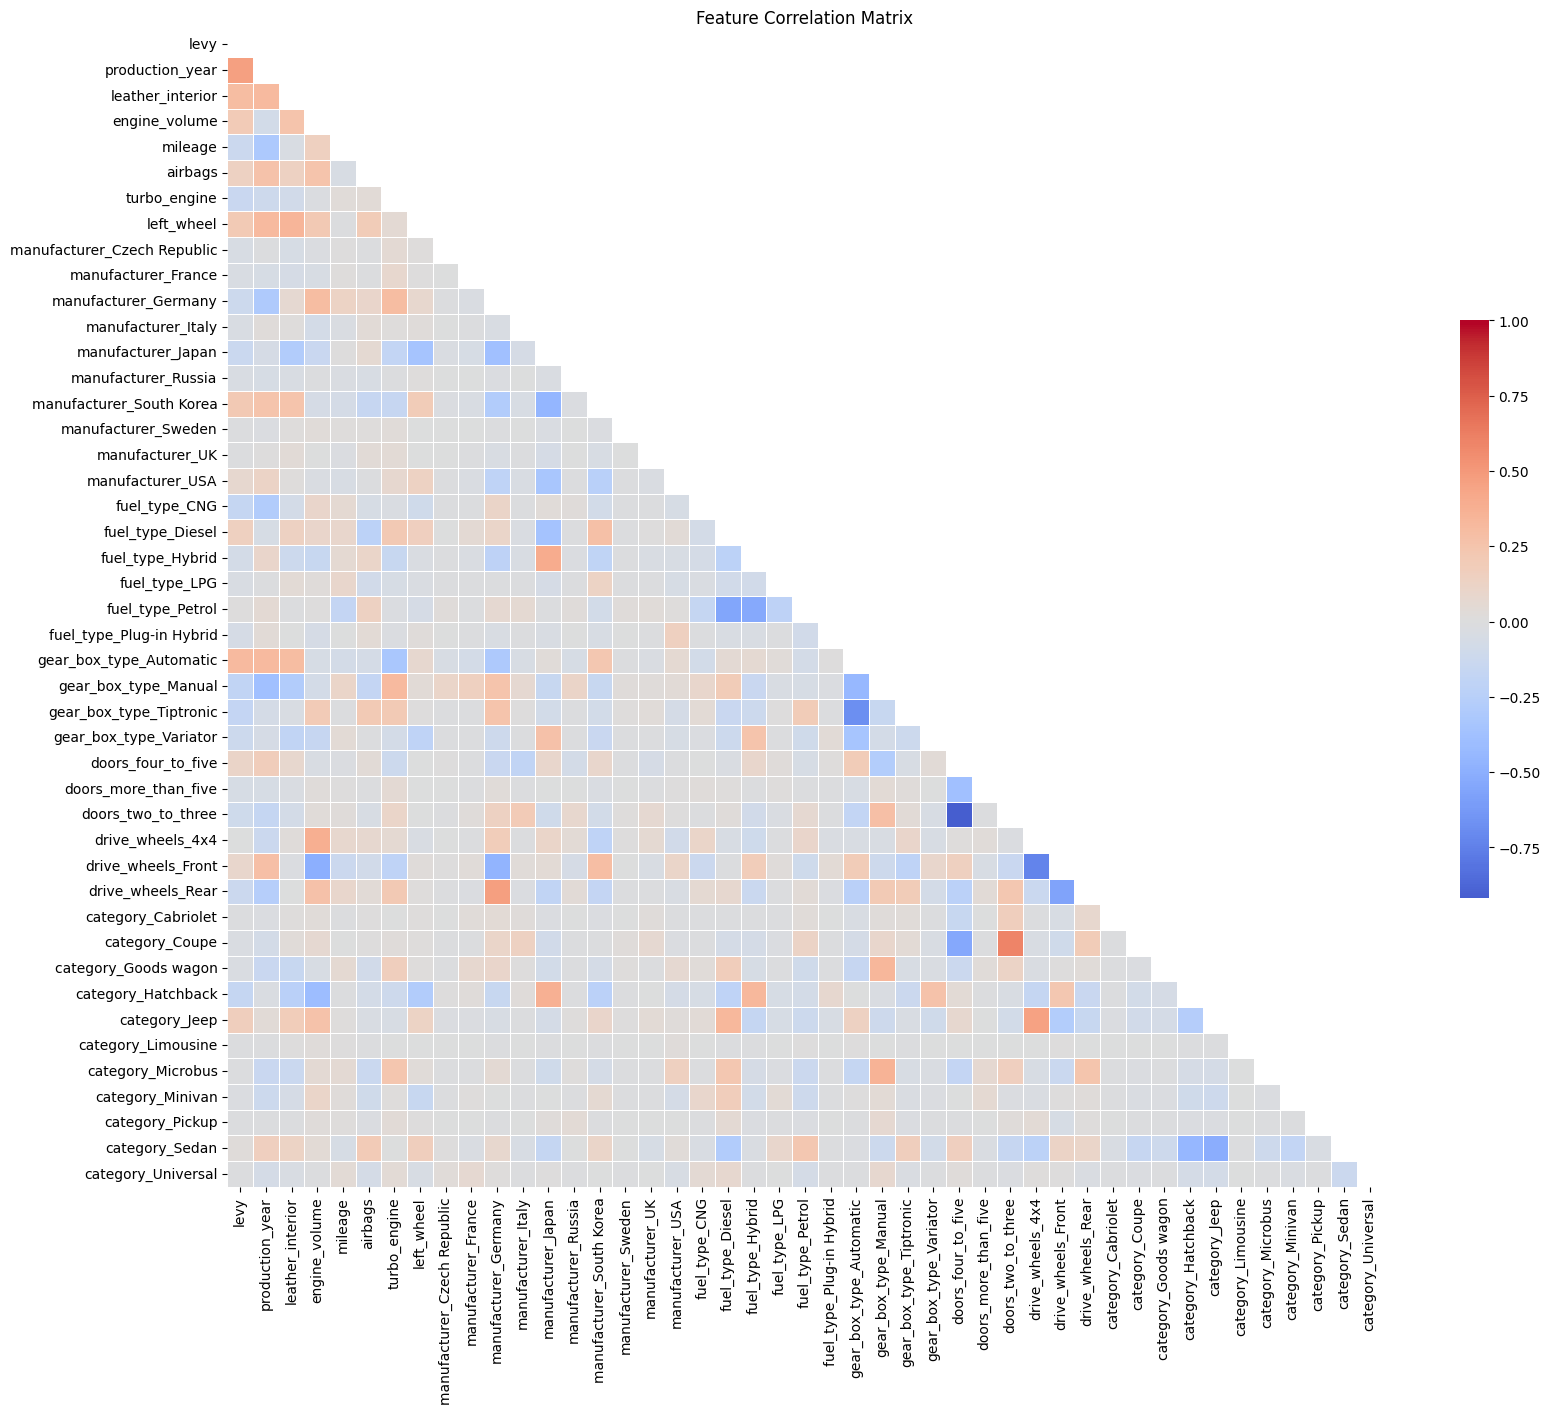

In [114]:
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Matrix')
plt.show()

In [115]:
threshold = 0.6
corr_matrix = X.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

X_reduced_corr = X.drop(to_drop, axis=1)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced_corr, y, test_size=0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [117]:
%%time
param_distributions = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

my_rf_corr = MyRandomForestRegressorCV()
my_rf_corr.train_model(param_distributions, X_train, y_train)

y_pred_my_rf_corr_train = my_rf_corr.predict(X_train)
y_pred_my_rf_corr_test = my_rf_corr.predict(X_test)

mse_my_rf_corr_train, r2_my_rf_corr_train = evaluate(y_pred_my_rf_corr_train, y_train)
mse_my_rf_corr_test, r2_my_rf_corr_test = evaluate(y_pred_my_rf_corr_test, y_test)

rmse_my_rf_corr_train = np.sqrt(mse_my_rf_corr_train)
rmse_my_rf_corr_test = np.sqrt(mse_my_rf_corr_test)

print("Best Parameters of MyRandomForestRegressorCV:", my_rf_corr.best_params)
print(f"MyRandomForest - Train: Mean Squared Error: {mse_my_rf_corr_train}, R2 Score: {r2_my_rf_corr_train}  RMSE: {rmse_my_rf_corr_train}")
print(f"MyRandomForest - Test: Mean Squared Error: {mse_my_rf_corr_test}, R2 Score: {r2_my_rf_corr_test}  RMSE: {rmse_my_rf_corr_test}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters of MyRandomForestRegressorCV: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 30}
MyRandomForest - Train: Mean Squared Error: 16549626.457397154, R2 Score: 0.8309865819026299  RMSE: 4068.123210695216
MyRandomForest - Test: Mean Squared Error: 30296315.26038657, R2 Score: 0.6813727222973329  RMSE: 5504.208867801673
CPU times: user 4.89 s, sys: 177 ms, total: 5.06 s
Wall time: 49.1 s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   7.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=250; total time=  10.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.5s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   7.1s

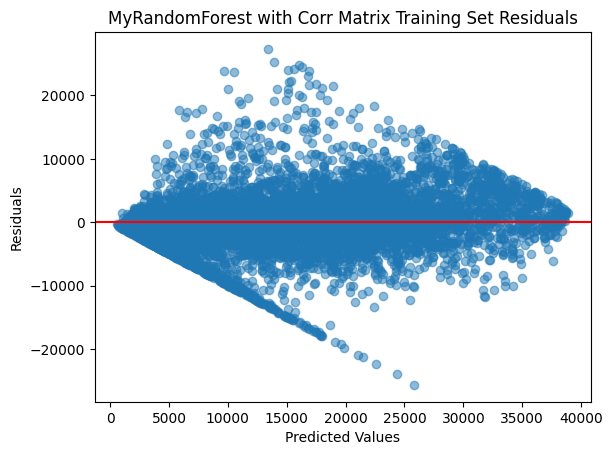

In [118]:
plot_residuals(y_train, y_pred_my_rf_corr_train, 'MyRandomForest with Corr Matrix Training Set Residuals')

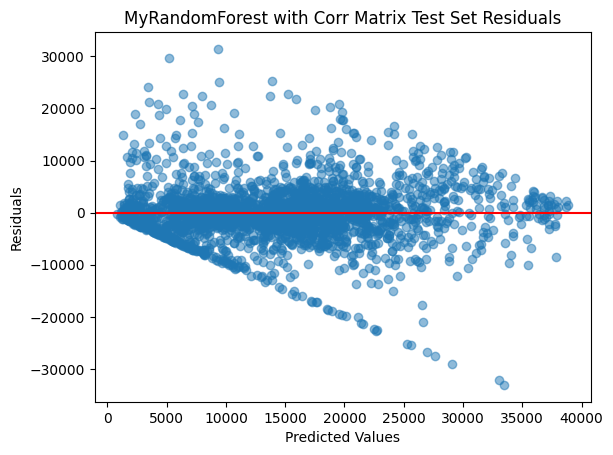

In [119]:
plot_residuals(y_test, y_pred_my_rf_corr_test, 'MyRandomForest with Corr Matrix Test Set Residuals')

## Podl’a dôležitosti prı́znakov z ensemble modelu;

In [133]:
importances = my_rf.best_rf.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False).head(12)

In [134]:
X_best_features = X[feature_importances['feature']]

In [135]:
X_best_features.columns

Index(['production_year', 'airbags', 'mileage', 'levy', 'fuel_type_Diesel',
       'engine_volume', 'gear_box_type_Tiptronic', 'leather_interior',
       'drive_wheels_Front', 'category_Jeep', 'turbo_engine',
       'gear_box_type_Automatic'],
      dtype='object')

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X_best_features, y, test_size=0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [137]:
%%time
param_distributions = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

my_rf_features = MyRandomForestRegressorCV()
my_rf_features.train_model(param_distributions, X_train, y_train)

y_pred_my_rf_features_train = my_rf_features.predict(X_train)
y_pred_my_rf_features_test = my_rf_features.predict(X_test)

mse_my_rf_features_train, r2_my_rf_features_train = evaluate(y_pred_my_rf_features_train, y_train)
mse_my_rf_features_test, r2_my_rf_features_test = evaluate(y_pred_my_rf_features_test, y_test)

rmse_my_rf_features_train = np.sqrt(mse_my_rf_features_train)
rmse_my_rf_features_test = np.sqrt(mse_my_rf_features_test)

print(f"MyRandomForest - Train: Mean Squared Error: {mse_my_rf_features_train}, R2 Score: {r2_my_rf_features_train} RMSE: {rmse_my_rf_features_train}")
print(f"MyRandomForest - Test: Mean Squared Error: {mse_my_rf_features_test}, R2 Score: {r2_my_rf_features_test}  RMSE: {rmse_my_rf_features_test}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MyRandomForest - Train: Mean Squared Error: 18120734.597247265, R2 Score: 0.8149416060477228 RMSE: 4256.84561585774
MyRandomForest - Test: Mean Squared Error: 33240446.25610725, R2 Score: 0.6504092062293214  RMSE: 5765.45282316205
CPU times: user 3.15 s, sys: 195 ms, total: 3.34 s
Wall time: 36.6 s


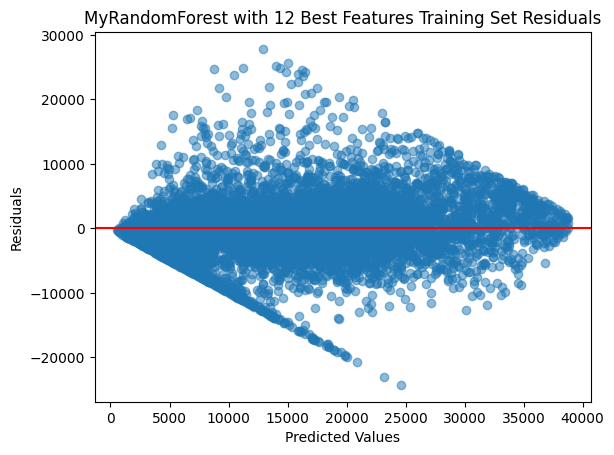

In [145]:
plot_residuals(y_train, y_pred_my_rf_features_train, 'MyRandomForest with 12 Best Features Training Set Residuals')

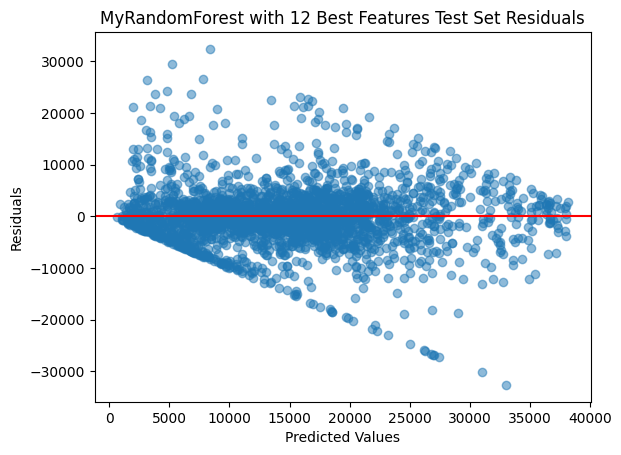

In [146]:
plot_residuals(y_test, y_pred_my_rf_features_test, 'MyRandomForest with 12 Best Features Test Set Residuals')

## Podl’a variancie pomocou PCA

In [147]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [148]:
variance_threshold = 0.90

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

total_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(total_variance >= variance_threshold)[0][0] + 1

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of components chosen: {n_components}")

Number of components chosen: 30


In [142]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=RANDOM_SEED)

In [151]:
%%time
param_distributions = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

my_rf_pca = MyRandomForestRegressorCV()
my_rf_pca.train_model(param_distributions, X_train, y_train)

y_pred_my_rf_pca_train = my_rf_pca.predict(X_train)
y_pred_my_rf_pca_test = my_rf_pca.predict(X_test)

mse_my_rf_pca_train, r2_my_rf_pca_train = evaluate(y_pred_my_rf_pca_train, y_train)
mse_my_rf_pca_test, r2_my_rf_pca_test = evaluate(y_pred_my_rf_pca_test, y_test)

rmse_my_rf_pca_train = np.sqrt(mse_my_rf_pca_train)
rmse_my_rf_pca_test = np.sqrt(mse_my_rf_pca_test)

print(f"MyRandomForest - Train: Mean Squared Error: {mse_my_rf_pca_train}, R2 Score: {r2_my_rf_pca_train}, RMSE: {rmse_my_rf_pca_train}")
print(f"MyRandomForest - Test: Mean Squared Error: {mse_my_rf_pca_test}, R2 Score: {r2_my_rf_pca_test}, RMSE: {rmse_my_rf_pca_test}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MyRandomForest - Train: Mean Squared Error: 13188804.587888964, R2 Score: 0.8653090479259089, RMSE: 3631.6393802095718
MyRandomForest - Test: Mean Squared Error: 35131202.19018048, R2 Score: 0.6305240680236983, RMSE: 5927.15801967355
CPU times: user 28.3 s, sys: 185 ms, total: 28.5 s
Wall time: 5min 9s


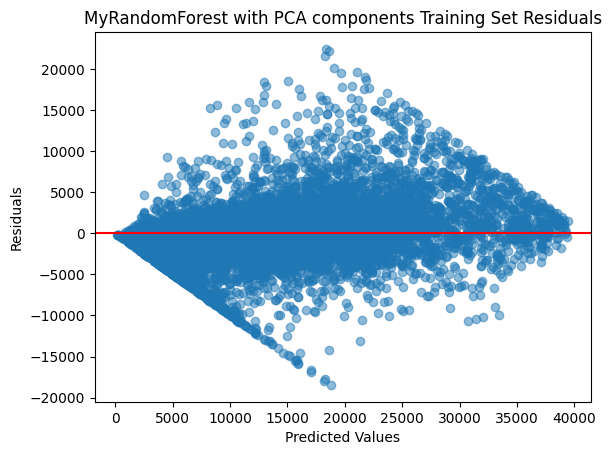

In [152]:
plot_residuals(y_train, y_pred_my_rf_pca_train, 'MyRandomForest with PCA components Training Set Residuals')

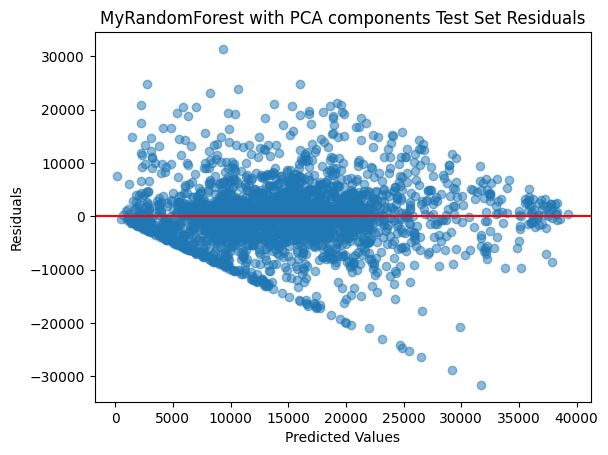

In [153]:
plot_residuals(y_test, y_pred_my_rf_pca_test, 'MyRandomForest with PCA components Test Set Residuals')

In [155]:
pd.options.display.float_format = '{:.2e}'.format 
data = [
    [mse_my_rf_corr_train, rmse_my_rf_corr_train, r2_my_rf_corr_train, mse_my_rf_corr_test, rmse_my_rf_corr_test, r2_my_rf_corr_test],
    [mse_my_rf_features_train, rmse_my_rf_features_train, r2_my_rf_features_train, mse_my_rf_features_test, rmse_my_rf_features_test, r2_my_rf_features_test],
    [mse_my_rf_pca_train, rmse_my_rf_pca_train, r2_my_rf_pca_train, mse_my_rf_pca_test, rmse_my_rf_pca_test, r2_my_rf_pca_test]
]

metrics = pd.DataFrame(
    index=['RF with Corr Matrix', 'RF with 12 Best Features', 'RF with PCA components'],
    columns=['MSE Train', 'RMSE Train', 'R2 Train', 'MSE Test', 'RMSE Test', 'R2 Test'],
    data=data
)
print(metrics)

                          MSE Train  RMSE Train  R2 Train  MSE Test   
RF with Corr Matrix        1.65e+07    4.07e+03  8.31e-01  3.03e+07  \
RF with 12 Best Features   1.81e+07    4.26e+03  8.15e-01  3.32e+07   
RF with PCA components     1.32e+07    3.63e+03  8.65e-01  3.51e+07   

                          RMSE Test  R2 Test  
RF with Corr Matrix        5.50e+03 6.81e-01  
RF with 12 Best Features   5.77e+03 6.50e-01  
RF with PCA components     5.93e+03 6.31e-01  
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  54.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  53.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=250; total time= 1.1min
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  39.3s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=  46.6s
[CV] END max_depth=10,

## Zhlukovanie dat

In [38]:
X_clusters = X.copy()

In [39]:
%%time
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_SEED)
    kmeans.fit(X_clusters)
    inertia.append(kmeans.inertia_)

CPU times: user 1min 51s, sys: 32.6 s, total: 2min 23s
Wall time: 19.2 s


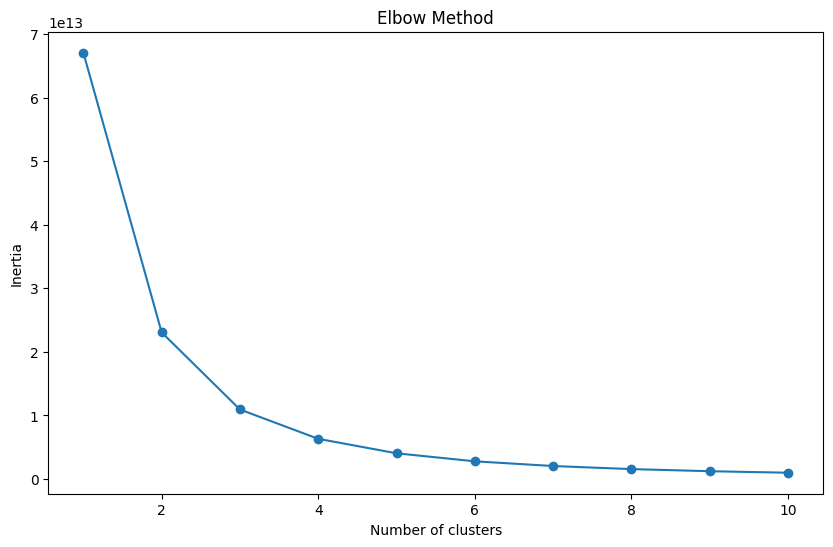

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [41]:
%%time
silhouette_scores = []
for i in range(2, 11):  # Starts from 2 clusters because silhouette score requires more than one cluster
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_SEED)
    kmeans.fit(X_clusters)
    cluster_labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_clusters, cluster_labels))

CPU times: user 2min 5s, sys: 1min 10s, total: 3min 15s
Wall time: 32.6 s


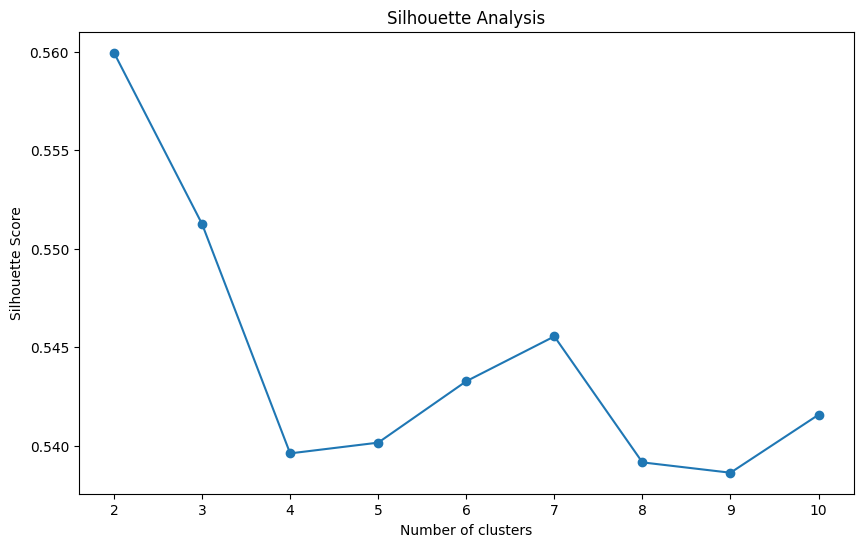

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [54]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_SEED)
X_clusters['cluster'] = kmeans.fit_predict(X_clusters)

In [55]:
feature1, feature2, feature3 = 'production_year', 'mileage', 'levy'

In [56]:
plot_3d_features(X_clusters, feature1, feature2, feature3, 'cluster')

In [46]:
# X_train, X_test, y_train, y_test = train_test_split(X_clusters, y, test_size=0.2, random_state=RANDOM_SEED)

In [47]:
# %%time
# param_distributions = {
#     'n_estimators': [50, 100, 150, 200, 250],
#     'max_depth': [10, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# my_rf_clusters = MyRandomForestRegressorCV()
# my_rf_clusters.train_model(param_distributions, X_train, y_train)

# y_pred_my_rf_clusters_train = my_rf_features.predict(X_train)
# y_pred_my_rf_clusters_test = my_rf_features.predict(X_test)

# mse_my_rf_clusters_train, r2_my_rf_clusters_train = evaluate(y_pred_my_rf_clusters_train, y_train)
# mse_my_rf_clusters_test, r2_my_rf_clusters_test = evaluate(y_pred_my_rf_clusters_test, y_test)

# print(f"MyRandomForest - Train: Mean Squared Error: {mse_my_rf_clusters_train}, R2 Score: {r2_my_rf_clusters_train}")
# print(f"MyRandomForest - Test: Mean Squared Error: {mse_my_rf_clusters_test}, R2 Score: {r2_my_rf_clusters_test}")